# This notebook is based on the paper: "Global-Convergence-Nonconvex-Optimization". 

The aim of this project is to find the global solution to  
\begin{equation}
  \min_{x \in \mathbb{R}^n} f(x).
\end{equation}

To obtain a global minimizer, the main idea is to minimize the Moreau Envelop instead, which "convexifies" the original function. To make the Moreau envelope tractable, we use connections to Hamilton-Jacobi Equations via the Cole-Hopf and Hopf-Lax formulas to efficiently compute the gradients of the Moreau envelope.

In [6]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import time
import random
from typing import Optional 

epsilon_double = np.finfo(np.float64).eps

from test_functions import Griewank, AlpineN1, Drop_Wave, Levy, Rastrigin, Ackley
from test_functions import Griewank_numpy, AlpineN1_numpy, Drop_Wave_numpy, Levy_numpy, Rastrigin_numpy, Ackley_numpy

from test_functions import MultiMinimaFunc, MultiMinimaAbsFunc
from test_functions import MultiMinimaFunc_numpy, MultiMinimaAbsFunc_numpy

seed   = 30
torch.manual_seed(seed)

### Create Class for Hamilton-Jacobi Moreau Adaptive Descent (HJ_MAD)

The Moreau envelop of $f$ is given by
\begin{equation}
  u(x,t) \triangleq \inf_{z\in \mathbb{R}^n} f(z) + \dfrac{1}{2t}\|z-x\|^2.
\end{equation}

We leverage the fact that the solution to the Moreau envelope above satisfies the Hamilton-Jacobi Equation
\begin{equation}
  \begin{split}
    u_t^\delta  + \frac{1}{2}\|Du^\delta  \|^2 \ = \frac{\delta}{2} \Delta u^\delta \qquad &\text{ in }  \mathbb{R}^n\times (0,T]
    \\
    u = f \qquad &\text{ in } \mathbb{R}^n\times \{t = 0\}
  \end{split}
\end{equation}
when $\delta = 0$. 

By adding a viscous term ($\delta > 0$), we are able to approximate the solution to the HJ equation using the Cole-Hopf formula to obtain
\begin{equation}
  u^\delta(x,t) = - \delta \ln\Big(\Phi_t * \exp(-f/\delta)\Big)(x) = - \delta \ln \int_{\mathbb{R}^n} \Phi(x-y,t)  \exp\left(\frac{-f(y)}{\delta}\right) dy 
\end{equation}
where 
\begin{equation}
  \Phi(x,t) = \frac{1}{{(4\pi \delta t)}^{n/2}} \exp{\frac{-\|x\|^2}{4\delta t}}. 
\end{equation}
This allows us to write the Moreau Envelope (and its gradient) explicitly as an expectation. In this case, we compute the gradient as
\begin{equation}
  \nabla u^\delta(x,t) = \dfrac{1}{t}\cdot  \dfrac{\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[(x-y) \exp\left(-\delta^{-1}\tilde{f}(y)\right) \right]}
    {\mathbb{E}_{y\sim  \mathbb{P}_{x,t}}\left[ \exp\left(-\delta^{-1} \tilde{f}(y)\right) \right]}
\end{equation}


### Define classes for HJ-MD-LS

In [7]:

from hj_md_ls import HJ_MD_LS

### Set up hyperparameters for HJ-MAD for different functions

In [8]:
# # Default values
delta         = 5e-2
max_iters     = int(1e4) #int(1e5)
tol           = 5e-3#7e-4


# Set the number of trials to run
avg_trials = 1
sat_tol = 1e-8

# # # def f(x):
# # #   return MultiMinimaFunc(x)
# # # def f_numpy(x):
# # #   return MultiMinimaFunc_numpy(x)
# # # ax_bry  = 30
# # # f_name  = 'MultiMinimaFunc'
# # # dim = 1; int_samples = int(100);
# # # x0      = -30*torch.ones(dim, dtype=torch.double)
# # # x_true  = -1.51034569*torch.ones(dim, dtype=torch.double)

# # # delta         = 0.1
# # # max_iters     = int(100)
# # # tol           = 1e-3
# # # momentum = 0.5

# # # theta         = 1.0 # note: larger theta => easier to increase time
# # # beta          = 0.0
# # # t_min     = 1e-1
# # # t_max     = 300
# # # t_init    = 220
# # # alpha     = 0.1
# # # eta_min = 0.99
# # # eta_plus = 5.0
# # # eta_vec = [eta_min, eta_plus]


# # # # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Griewank(x)
# def f_numpy(x):
#   return Griewank_numpy(x)
# ax_bry  = 20
# f_name  = 'Griewank'
# dim = 2; int_samples = int(5);
# int_samples_line = int(10000)
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)


# max_iters     = int(1e5)

# delta         = 1e-3#1e-6 #1e-6

# tol           = 5e-3

# t    = 1e4



# # # ---------------------------------------------------------------------------------------------------- To Test:

# avg_trials = 1
# max_iters     = int(1e5)

# def f(x):
#   return Griewank(x)
# def f_numpy(x):
#   return Griewank_numpy(x)
# ax_bry  = 20
# f_name  = 'Griewank'
# dim = 500; int_samples = int(2)
# int_samples_line = int(1e2)
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)
# rescale0      = 2**(-13)
# delta         = 1e-6 #1e-6

# tol           = 5e-3

# t    = 1e-2/delta

# # # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Drop_Wave(x)
# def f_numpy(x):
#   return Drop_Wave_numpy(x)
# ax_bry  = 20

# f_name  = 'Drop_Wave'
# rescale0      = 1
# dim = 2; int_samples = int(300)
# int_samples_line = int(100000)
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# delta         = 1e-6

# t = int(2e1)/1e-4#delta


# # # # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return AlpineN1(x)
# def f_numpy(x):
#   return AlpineN1_numpy(x)
# ax_bry  = 20
# f_name  = 'AlpineN1'

# dim = 2; int_samples = int(200)
# int_samples_line = int(10000)
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)
# delta         = 5e-6


# t = int(2e1)/5e-4

# # # ----------------------------------------------------------------------------------------------------
# avg_trials = 1
# def f(x):
#   return Levy(x)
# def f_numpy(x):
#   return Levy_numpy(x)

# ax_bry  = 20
# f_name  = 'Levy'

# # Set the number of trials to run
# rescale0 = 1
# tol           = 5e-3
# sat_tol = 1e-5
# max_iters     = int(5e2)
# delta         = 1e-4


# dim = 2; 
# int_samples = int(10)
# int_samples_line = int(10000)
# x0      = -15*torch.ones(dim, dtype=torch.double)
# # x0[1] = 0
# x_true  = torch.ones(dim, dtype=torch.double)

# t     = 1e4 # int(2e2)/delta

# avg_trials = 1
# def f(x):
#   return Levy(x)
# def f_numpy(x):
#   return Levy_numpy(x)

# ax_bry  = 20
# f_name  = 'Levy'

# # Set the number of trials to run
# rescale0 = 1
# tol           = 5e-3
# sat_tol = 1e-5
# max_iters     = int(5e2)
# delta         = 1e-4


# dim = 2; 
# int_samples = int(1000)
# int_samples_line = int(10000)
# x0      = -15*torch.ones(dim, dtype=torch.double)
# # x0[1] = 0
# x_true  = torch.ones(dim, dtype=torch.double)

# t     = 1e4 # int(2e2)/delta

# # # ----------------------------------------------------------------------------------------------------

# avg_trials = 1
# def f(x):
#   return Levy(x)
# def f_numpy(x):
#   return Levy_numpy(x)

# ax_bry  = 20
# f_name  = 'Levy'

# # Set the number of trials to run
# rescale0 = 1
# tol           = 5e-3
# sat_tol = 1e-5
# max_iters     = int(5e2)
# delta         = 1e-5


# dim = 2; 
# int_samples = int(100)
# int_samples_line = int(10000)
# x0      = -15*torch.ones(dim, dtype=torch.double)
# x0[1] = 0
# x_true  = torch.ones(dim, dtype=torch.double)

# t     = 1e4 # int(2e2)/delta



# # # ----------------------------------------------------------------------------------------------------


avg_trials = 1
def f(x):
  return Levy(x)
def f_numpy(x):
  return Levy_numpy(x)

ax_bry  = 20
f_name  = 'Levy'

# Set the number of trials to run
dim = 20; 
x0      = -15*torch.ones(dim, dtype=torch.double)
x_true  = torch.ones(dim, dtype=torch.double)
tol           = 5e-3
sat_tol = 1e-3
max_iters     = int(10000)

# Important parameters
delta         = 100#1e-8
delta_dampener = 0.8
t     = 1e-2

int_samples = int(100000)
int_samples_line = int(100000)

# # # ----------------------------------------------------------------------------------------------------

# avg_trials = 1
# def f(x):
#   return Levy(x)
# def f_numpy(x):
#   return Levy_numpy(x)

# ax_bry  = 20
# f_name  = 'Levy'

# # Set the number of trials to run
# dim = 500; 
# x0      = -15*torch.ones(dim, dtype=torch.double)
# x_true  = torch.ones(dim, dtype=torch.double)
# tol           = 5e-4
# sat_tol = 1e-5
# max_iters     = int(1e3)

# # Important parameters
# delta         = 1e-3 # Smaller delta => more samples required but fewer iterations
# t     = 100#int(2e2)/delta

# int_samples = int(100)
# int_samples_line = int(500)


# # # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Rastrigin(x)
# def f_numpy(x):
#   return Rastrigin_numpy(x)
# ax_bry  = 20
# f_name  = 'Rastrigin'

# delta         = 5e-5
# dim = 2; int_samples = int(9);
# int_samples_line = int(100000)
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# t = int(2e1)/5e-2



# # # # ----------------------------------------------------------------------------------------------------

# def f(x):
#   return Ackley(x)
# def f_numpy(x):
#   return Ackley_numpy(x)
# ax_bry  = 20
# f_name  = 'Ackley'

# dim = 2; int_samples = int(5);
# int_samples_line = int(100000)
# x0      = 10*torch.ones(dim, dtype=torch.double)
# x_true  = torch.zeros(dim, dtype=torch.double)

# t = int(2e1)/delta


## Line Search Version 

In [9]:


hj_md_ls = HJ_MD_LS(f,f_numpy,f_name, x_true, delta=delta,
                    int_samples=int_samples,int_samples_line=int_samples_line, t=t, max_iters=max_iters, tol=tol, 
                    verbose=True,saturate_tol=sat_tol,integration_method="MC",delta_dampener=delta_dampener)


+---------------------+-----------+
|      Parameter      |   Value   |
+---------------------+-----------+
|       f_name        |   Levy    |
| Dimensions/Features |    20     |
|        delta        |    100    |
|          t          | 1.000e-02 |
|     int_samples     | 1.000e+05 |
|  int_samples_line   | 1.000e+05 |
|      max_iters      | 1.000e+04 |
|         tol         |   0.005   |
|      rescale0       | 1.000e-01 |
|    saturate_tol     | 1.000e-03 |
+---------------------+-----------+


In [10]:
# Initialize accumulators for averages
avg_func_evals = 0
sum_elapsed_time = 0
total_iterations = 0  # To store total iterations across trials
avg_completion_error = 0  # To store completion error across trials
avg_rescale_factor_reached = 0  # To store rescale factor reached across trials
convergened_count = 0
avg_successful_ls = 0
# Run the specified number of trials
for _ in range(avg_trials):
    start_time = time.time()  # Record the start time
    hj_md_ls.t = t


    # Execute the HJ_MAD_CD algorithm and retrieve results
    x_opt_ls, xk_hist_ls, xk_error_hist_ls, fk_hist_ls, successful_ls_portion = hj_md_ls.run(x0)

    elapsed_time = time.time() - start_time  # Calculate elapsed time
    sum_elapsed_time += elapsed_time  # Accumulate elapsed time

    total_iterations += len(xk_error_hist_ls)-1  # Add iterations used in this trial
    avg_func_evals += len(xk_error_hist_ls) * int_samples  # Update average function evaluations
    avg_completion_error += torch.norm(x_opt_ls -x_true) # Ensure the final error is the true error 
    avg_successful_ls += successful_ls_portion
    avg_rescale_factor_reached += hj_md_ls.rescale0

    if xk_error_hist_ls[-1] <= tol:
        convergened_count += 1


    #print(f"Elapsed time: {elapsed_time:.4f} seconds")  # Print elapsed time for the current trial

# Compute averages after all trials
avg_func_evals /= avg_trials  # Average function evaluations per trial
average_iterations = total_iterations / avg_trials  # Average number of iterations per trial
avg_completion_error /= avg_trials  # Average completion error across all trials
avg_rescale_factor_reached /= avg_trials  # Average rescale factor reached across all trials
portion_converged = convergened_count / avg_trials
avg_successful_ls /= avg_trials
# Output results
print(f"\n\nSummary of Results for {avg_trials} Trials HJ-MD-LS:")
print("=" * 40)
#print(f"{'Average Function Evaluations:':<35} {avg_func_evals}")
print(f"{'Average Completion Error:':<35} {avg_completion_error:.2e} (Tolerance: {tol:.2e})")
print(f"{'Portion Converged:':<35} {portion_converged:.2%}")
print(f"{'Average Successful Linesearch:':<35} {avg_successful_ls:.2%}")
print(f"{'Average Iterations to Convergence/Stopping:':<35} {average_iterations:.2f}")
print(f"{'Average Rescale Factor Reached:':<35} {avg_rescale_factor_reached:.2e}")
print(f"{'Average Elapsed Time:':<35} {sum_elapsed_time / avg_trials:.4f} seconds")

-------------------------- RUNNING Algorithm ---------------------------
dimension =  20 n_samples =  100000
[  0]: fk = 2.47e+03 | xk_err = 7.16e+01 
Samples taken into account by softmax: 74034
argmin f(y): 2859.7874112900768
softmax f(y): 809.6805460157018
f(xk): 2472.5431915516565
delta: 100
f_prox_new=tensor([1249.8966], dtype=torch.float64)
Prox_xk_new error: 7.41e+01
No improvement in line search
[  1]: fk = 8.10e+02 | xk_err = 4.96e+01 
Samples taken into account by softmax: 74195
argmin f(y): 977.4095593991619
softmax f(y): 334.7905401180142
f(xk): 809.6805460157018
delta: 100
f_prox_new=tensor([793.8770], dtype=torch.float64)
Prox_xk_new error: 4.92e+01
No improvement in line search
[  2]: fk = 3.35e+02 | xk_err = 2.84e+01 
Samples taken into account by softmax: 74221
argmin f(y): 820.484054006748
softmax f(y): 91.62274725836336
f(xk): 334.7905401180142
delta: 100
f_prox_new=tensor([326.1770], dtype=torch.float64)
Prox_xk_new error: 2.82e+01
No improvement in line search
[  3

### Generate Convergence Histories and Optimization Path Plots

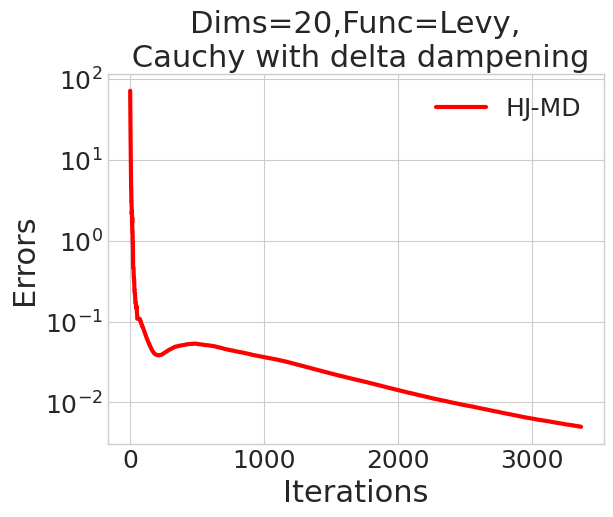

In [17]:

title_fontsize = 22
fontsize       = 18
fig1 = plt.figure()

plt.style.use('seaborn-whitegrid')
ax = plt.axes()

# ax.semilogy(xk_error_hist_MAD, color='red', linewidth=3)
# ax.semilogy(xk_error_hist, color='blue', linewidth=3);
#ax.semilogy(xk_error_hist_no_mo, color='green', linestyle='--', linewidth=3);
ax.semilogy(xk_error_hist_ls, color='red', linewidth=3);
# ax.semilogy(xk_error_hist_ls_no_mo, color='red', linestyle='--', linewidth=3);

ax.set_title(f'Dims={dim},Func={f_name},\n Cauchy with delta dampening', fontsize=title_fontsize)
ax.set_xlabel("Iterations", fontsize=title_fontsize)
ax.set_ylabel("Errors", fontsize=title_fontsize)
ax.legend(['HJ-MD','HJ-MD-LS'],fontsize=fontsize)
# title_str = 'Relative Errors'
# ax.set_title(title_str, fontsize=title_fontsize)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

# save_str = 'griewank_error_hist.png'
# fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

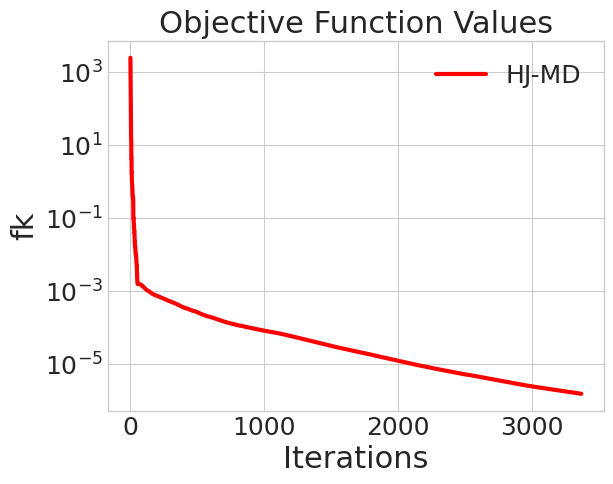

In [12]:
fig1 = plt.figure()

plt.style.use('seaborn-whitegrid')
ax = plt.axes()
#ax.semilogy(fk_hist, color='blue', linewidth=3);
#ax.semilogy(fk_hist_no_mo, color='green', linestyle='--', linewidth=3);
ax.semilogy(fk_hist_ls, color='red', linewidth=3);
#ax.semilogy(fk_hist_ls_no_mo, color='red', linestyle='--', linewidth=3);

ax.set_xlabel("Iterations", fontsize=title_fontsize)
ax.set_ylabel("fk", fontsize=title_fontsize)
ax.legend(['HJ-MD','HJ-MD-LS'],fontsize=fontsize)
title_str = 'Objective Function Values'
ax.set_title(title_str, fontsize=title_fontsize)
ax.tick_params(labelsize=fontsize, which='both', direction='in')

# save_str = 'griewank_func_hist.png'
# fig1.savefig(save_str, dpi=300 , bbox_inches="tight", pad_inches=0.0)

## 2D Plots


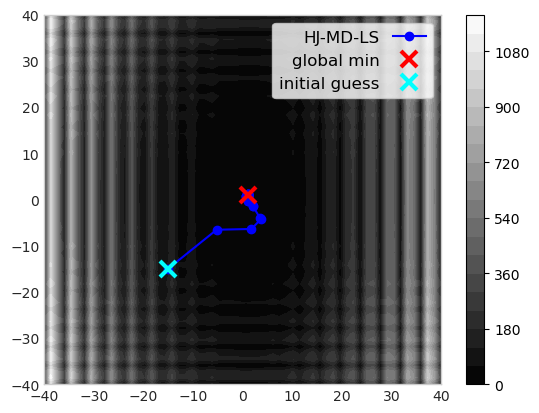

In [13]:
# if dim == 2:

if f_name == 'Levy':
  x0      = -15*torch.ones(dim, dtype=torch.double)
  x_true  = torch.ones(dim, dtype=torch.double)
else:
  x0      = 10*torch.ones(dim, dtype=torch.double)
  x_true  = torch.zeros(dim, dtype=torch.double)

surface_plot_resolution = 60
ax_bry = 40

x = np.linspace(-ax_bry, ax_bry, surface_plot_resolution)
y = np.linspace(-ax_bry, ax_bry, surface_plot_resolution)

X, Y = np.meshgrid(x, y)
n_features = 2

t_final = t

Z                 = np.zeros(X.shape)
Z_MAD             = np.zeros(X.shape)

for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    Z[i,j] = f(torch.FloatTensor([X[i,j],Y[i,j]]).view(1,n_features))  
    

fig, ax = plt.subplots(1, 1)
im = ax.contourf(X, Y, Z, 20, cmap=plt.get_cmap('gray'))
plt.style.use('default')

title_fontsize = 22
fontsize       = 15
#coordinate_wise_xk_hist_np = np.vstack(xk_hist)


#ax.plot(np.vstack(xk_hist)[:,0], np.vstack(xk_hist)[:,1], 'g-o')

#ax.plot(np.vstack(xk_hist_no_mo)[:,0], np.vstack(xk_hist_no_mo)[:,1], '-o', color='purple')

ax.plot(np.vstack(xk_hist_ls)[:,0], np.vstack(xk_hist_ls)[:,1], 'b-o')


ax.plot(x_true[0], x_true[1], 'rx', markeredgewidth=3, markersize=12)
ax.plot(x0[0], x0[1], 'x', markeredgewidth=3, markersize=12, color='cyan')

ax.legend([ 'HJ-MD-LS', 'global min', 'initial guess'], fontsize=12, facecolor='white', markerfirst=False)

ax.set_xlim(-ax_bry,ax_bry)
cb = plt.colorbar(im)

# save_loc = 'optimization_paths.png'
# plt.savefig(save_loc,bbox_inches='tight')
plt.show()

## Interactive 2D Plot


In [14]:
if dim == 2:
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import numpy as np

    ax_bry_3D_plot = 20
    surface_plot_resolution = 50
    x = np.linspace(-ax_bry_3D_plot, ax_bry_3D_plot, surface_plot_resolution)
    y = np.linspace(-ax_bry_3D_plot, ax_bry_3D_plot, surface_plot_resolution)

    X, Y = np.meshgrid(x, y)
    # Convert PyTorch tensors to NumPy
    # xk_hist_MAD_np = xk_hist_MAD.numpy()
    coordinate_wise_xk_hist_np = np.vstack(xk_hist_cd)

    # # Ensure z_values are scalars
    # HJ_MAD_f_values = np.array([
    #     f(torch.FloatTensor([[xk_hist_MAD_np[i, 0], xk_hist_MAD_np[i, 1]]])).item()
    #     for i in range(len(xk_hist_MAD_np))
    # ])

    HJ_MAD_CD_f_values = np.array([
        f(torch.FloatTensor([[coordinate_wise_xk_hist_np[i, 0], coordinate_wise_xk_hist_np[i, 1]]])).item()
        for i in range(len(coordinate_wise_xk_hist_np))
    ])

    # Global minimum and initial guess
    if x_true.dim() == 1:
        x_true = x_true.unsqueeze(0)
    global_min_f = f(x_true).item()

    # Initial guess point
    if x0.dim() == 1:
        x0 = x0.unsqueeze(0)
    f_initial = f(x0).item()


In [15]:
if dim == 2:
    import plotly.graph_objects as go

    # Create surface trace
    surface_trace = go.Surface(
        z=Z, x=X, y=Y, colorscale='Viridis', showscale=True, name='Surface'
    )

    # # Create optimization paths
    # HJ_MAD_trace = go.Scatter3d(
    #     x=xk_hist_MAD_np[:, 0],
    #     y=xk_hist_MAD_np[:, 1],
    #     z=HJ_MAD_f_values,
    #     mode='lines+markers',
    #     marker=dict(size=5, color='red'),
    #     line=dict(color='red', width=3),
    #     name='HJ-MAD'
    # )

    HJ_MAD_CD_trace = go.Scatter3d(
        x=coordinate_wise_xk_hist_np[:, 0],
        y=coordinate_wise_xk_hist_np[:, 1],
        z=HJ_MAD_CD_f_values,
        mode='lines+markers',
        marker=dict(size=5, color='blue'),
        line=dict(color='blue', width=3),
        name='HJ-MAD-CD'
    )

    # Global minimum point
    global_min_trace = go.Scatter3d(
        x=[x_true[0, 0].item()],
        y=[x_true[0, 1].item()],
        z=[global_min_f],
        mode='markers',
        marker=dict(size=8, color='black', symbol='x'),
        name='Global min'
    )

    # Initial guess point
    initial_guess_trace = go.Scatter3d(
        x=[x0[0, 0].item()],
        y=[x0[0, 1].item()],
        z=[f_initial],
        mode='markers',
        marker=dict(size=8, color='green', symbol='x'),
        name='Initial guess'
    )

    # Combine traces
    fig = go.Figure(data=[surface_trace, HJ_MAD_CD_trace, global_min_trace, initial_guess_trace])

    # Set layout details
    fig.update_layout(
        title="Interactive 3D Optimization Path",
        scene=dict(
            xaxis_title="X-axis",
            yaxis_title="Y-axis",
            zaxis_title="f-axis",
        ),
        margin=dict(l=0, r=0, t=40, b=0),
        legend=dict(
            x=0.02,  # Adjust the x position of the legend
            y=0.98,  # Adjust the y position of the legend
            bgcolor='rgba(255, 255, 255, 0.5)',  # Set background color with transparency
        )
    )

    # Show interactive plot
    fig.show(renderer="notebook")

In [16]:
if dim == 2:

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none', zorder=1)

    # # Plot the HJ-MAD optimization path
    # ax.plot(xk_hist_MAD_np[:, 0], xk_hist_MAD_np[:, 1], HJ_MAD_f_values, '-o', color='red', label="HJ-MAD", zorder=2)

    # Plot the HJ-MAD-CD optimization path
    ax.plot(coordinate_wise_xk_hist_np[:, 0], coordinate_wise_xk_hist_np[:, 1], HJ_MAD_CD_f_values, '-o', color='blue', label="HJ-MAD-CD", zorder=2)

    ax.plot(
        [x_true[0, 0].item()],  # Wrap in list
        [x_true[0, 1].item()],  # Wrap in list
        [global_min_f],  # Wrap in list
        'x', color='black', label="Global min", zorder=3
    )
    ax.plot(
        [x0[0, 0].item()],  # Wrap in list
        [x0[0, 1].item()],  # Wrap in list
        [f_initial],  # Wrap in list
        'x', color='green', label="Initial guess", zorder=3
    )

    # Set view angle
    ax.view_init(elev=50, azim=30)  # Increase the elevation angle to 90 degrees

    # Add labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('f-axis')
    ax.legend()

    plt.show()